# 3 Preprocessing and Training Data

## 3.1 Contents<a id='3.1_Contents'></a>
* [3 Exploratory Data Analysis](#3_Exploratory_Data_Analysis)
  * [3.1 Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
      * [3.2.1 Objective](#3.2.1_Objective)
  * [3.3 Imports](#3.3_Imports)
  * [3.4 Load The Data](#3.4_Load_The_Data)
    * [3.4.1 Explore The Data](#3.4.1_Explore_The_Data)
  * [3.5.1 Distributions](#3.5.1_Distributions)
      * [3.5.1.1 Variable Relationship](#3.5.1.1_Variable_Relationship)
      * [3.5.1.2 Scatterplots of features against price](#3.5.1.3_Scatterplots_of_features_against_price)
      * [3.5.1.3 Feature correlation heatmap](#3.5.1.3_Feature_correlation_heatmap)
      * [3.5.1.4 Borough Distribution](#3.5.1.3_Borough_Distribution)    
      * [3.5.1.3 Neighborhood Average Price and Standard Deviation](#3.5.1.3_Neighborhood_Barplots)
  * [3.6 Visualization of Houses on Maps](#3.6_Bokeh_visualization)
  * [3.7 Summary](#3.7_Summary)


## 3.2 Introduction<a id='3.2_Introduction'></a>

##### With completion of Data Wrangling and Exploration of our dataset we now start processing and gathering training data. Our clients Capital Fortune asked us to find the best housing models/types that would yield the highest return on investment.  Our target feature is price in our final dataframe, which will be predicting for house prices which we will later analysis upon which houses yield the highest returns on investment for Capital Fortune. 

### 3.2.1 Objective<a id='3.2.1_Objective'></a>

##### We want to make sure our data is as digestible as possible so we may implement machine learning algorithms to best estimate house prices, and which features leads to increased price on an house. We will start via analysis which features need to be re-evaluated and make proper adjustments so we may implement our algorithms with ease. For instances for catagorical variables we will need to utilize dummy variables so it can be inputed into our algorithm and etc. The main goal is to make our final dataset be able easily integratable into machine learning algorithms.

## 3.3 Imports<a id='3.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as tick
import sklearn.model_selection

import featuretools as ft
from sklearn import neighbors, datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

In [2]:
#This is a function by Dan Friedman to change the labels of large numbers 
#Here is a link
#https://dfrieds.com/data-visualizations/how-format-large-tick-values.html
sns.set(font_scale=1.4)

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

## 3.4 Load The Data<a id='3.4_Load_The_Data'></a>

In [3]:
df = pd.read_csv('../Data/final_nyc_df.csv')

### 3.4.1 Explore the data<a id='3.4.1_Explore_The_Data'></a>

In [4]:
print(df.shape)
print(df.describe())
print(df.dtypes)

(59262, 27)
           ZipCode      latitude     longitude         price  propertyTaxRate  \
count  59255.00000  59262.000000  59262.000000  5.926200e+04     59250.000000   
mean   10913.02977     40.696298    -73.926901  1.083250e+06         0.823852   
std      514.46863      0.094100      0.132106  2.347253e+06         0.098343   
min      148.00000     40.498634    -74.253983  1.000000e+05         0.650000   
25%    10314.00000     40.618461    -73.996172  5.100000e+05         0.840000   
50%    11210.00000     40.694778    -73.904606  7.000000e+05         0.840000   
75%    11367.00000     40.756160    -73.829042  9.900000e+05         0.870000   
max    13277.00000     40.912682    -73.700432  9.272502e+07         2.370000   

         Annual_Tax  Tax_Assessed_Value  Lot_Size(SqFT)    $_Per_SqFT  \
count  5.060600e+04        4.881500e+04    4.998600e+04  4.998600e+04   
mean   2.121627e+04        1.277692e+06    7.484192e+04  4.571731e+05   
std    1.812653e+05        9.550726e+06

##### We want to make sure our data-types are compatible so we should try to change all catagorical variables to either numeric representation or dummy variables

##### Lets start by working on Variables that are true and false by making them either 0 or 1 0 if false and 1 if true.

In [5]:
df.Basement = pd.get_dummies(df.Basement, drop_first=True).values
df.Cooling_Available = pd.get_dummies(df.Cooling_Available, drop_first=True).values
df.Fireplace_Available = pd.get_dummies(df.Fireplace_Available, drop_first=True).values
df.Heating_Available = pd.get_dummies(df.Heating_Available, drop_first=True).values
df.Spa_Available = pd.get_dummies(df.Spa_Available, drop_first=True).values

### 3.4.2 Fixing Categorical Data<a id='3.4.2_Fixing_Data'></a>

##### The zipcode only has 7 missing values I think it would appropriate to just fill in those missing values based on their address and location

In [6]:
df[df.ZipCode.isnull()]

City        Borough        Neighborhood  \
1128           Bronx          Bronx  University Heights   
4725           Bronx          Bronx       Fordham Manor   
8927          Queens         Queens    Long Island City   
21171  Staten island  Staten Island   Castleton Corners   
25046  Staten island  Staten Island          Charleston   
28989      Rochester         Queens             Jamaica   
34045       Brooklyn       Brooklyn      Brighton Beach   

               StreetAddress  ZipCode   latitude  longitude       price  \
1128            W Fordham Rd      NaN  40.861465 -73.914680  31550000.0   
4725              Bailey Ave      NaN  40.866638 -73.908234   2775000.0   
8927   50-02 Midtown Tun Plz      NaN  40.741753 -73.947235   1500000.0   
21171           N Gannon Ave      NaN  40.609570 -74.125153    500000.0   
25046          Englewood Ave      NaN  40.531796 -74.220421    130000.0   
28989               Cedar Dr      NaN  40.698139 -73.832207    115000.0   
34045       24 Brighton 3 Ln      NaN  40.579765 -73.964851    549000.0   

       propertyTaxRate  Annual_Tax  ...  Total_Bathrooms  Full_Bathrooms  \
1128              0.95     97169.0  ...              5.0             NaN   
4725              0.95        46.0  ...              3.0             NaN   
8927              0.84     64094.0  ...              3.0             NaN   
21171             0.87      2282.0  ...              3.0             NaN   
25046             0.87      2418.0  ...              2.0             NaN   
28989             2.37         NaN  ...              2.0             NaN   
34045             0.65      2500.0  ...              1.0             1.0   

       Half_Bathrooms  ParkingType Basement  Cooling_Available  \
1128              NaN     0 spaces        0                  0   
4725              NaN     0 spaces        0                  0   
8927              NaN     0 spaces        0                  0   
21171             NaN     0 spaces        0                  0   
25046             NaN     0 spaces        0                  0   
28989             NaN     0 spaces        0                  0   
34045             0.0         None        0                  0   

       Fireplace_Available  Heating_Available  Spa_Available  Story_Building  
1128                     0                  0              0             1.0  
4725                     0                  0              0             1.0  
8927                     0                  0              0             1.0  
21171                    0                  0              0             1.0  
25046                    0                  0              0             1.0  
28989                    0                  0              0             1.0  
34045                    0                  1              0             1.0  

[7 rows x 27 columns]

In [7]:
df.ZipCode.iloc[1128] = 10468
df.ZipCode.iloc[4725] = 10463
df.ZipCode.iloc[8927] = 11101
df.ZipCode.iloc[21171] = 10314
df.ZipCode.iloc[25046] = 10309
df.ZipCode.iloc[28989] = 11411
df.ZipCode.iloc[34045] = 11235

### We also need to fix categorical data into numerical representation via encoding 
#### While we can encode street address into different numbers but this would be very large thus I believe it provides no relative information that impact our target variable price thus this will also be dropped

#### After much analysis using randomforest most impactful features, as well as variance explained it was evident that feature ParkingType had little to no effect on price and given that it is a categorical data with over 600 different options it is clear that it should be dropped

In [8]:
df = df.drop(['StreetAddress','ParkingType'], axis=1)

##### We will convert HomeType catagorical values using dummy variable encoding with pandas get_dummies function

In [9]:
counts = df.HomeType.value_counts()
mask = df.HomeType.isin(counts[counts < 130].index)
df.HomeType[mask] = 'Other'
r_mask = df[df['HomeType'] == 'Residential Income']['HomeType'].index
df.HomeType[r_mask] = 'Residential'
df.HomeType = (pd.Categorical(df.HomeType))

In [10]:
df.HomeType = pd.Categorical(df.HomeType)
df.HomeType = df.HomeType.cat.codes

In [11]:
df.Borough = pd.Categorical(df.Borough)
df.Borough = df.Borough.cat.codes

In [12]:
df.City = pd.Categorical(df.City)
df.City = df.City.cat.codes

In [13]:
df.Neighborhood = pd.Categorical(df.Neighborhood)
df.Neighborhood = df.Neighborhood.cat.codes

In [14]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count', '%'])

count          %
City                        0   0.000000
Borough                     0   0.000000
Neighborhood                0   0.000000
ZipCode                     0   0.000000
latitude                    0   0.000000
longitude                   0   0.000000
price                       0   0.000000
HomeType                    0   0.000000
Bedrooms                    0   0.000000
Total_Bathrooms             0   0.000000
Basement                    0   0.000000
Cooling_Available           0   0.000000
Fireplace_Available         0   0.000000
Heating_Available           0   0.000000
Spa_Available               0   0.000000
Story_Building              0   0.000000
propertyTaxRate            12   0.020249
YearBuilt                3875   6.538760
LivingArea_Space(SqFT)   7189  12.130876
Annual_Tax               8656  14.606324
Lot_Size(SqFT)           9276  15.652526
$_Per_SqFT               9276  15.652526
Tax_Assessed_Value      10447  17.628497
Half_Bathrooms          13919  23.487226
Full_Bathrooms          13981  23.591846

## 3.5 Train/Test_Split<a id='3.5_Train/Test_Split'></a>

In [15]:
X = df.drop([ 'price', '$_Per_SqFT'] ,axis=1)
y = df.price

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100)

TypeError: Singleton array array(11850.01) cannot be considered a valid collection.

In [17]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(41483, 23) (17779, 23)
(41483,) (17779,)


In [18]:
X_train.dtypes

City                        int16
Borough                      int8
Neighborhood                int16
ZipCode                   float64
latitude                  float64
longitude                 float64
propertyTaxRate           float64
Annual_Tax                float64
Tax_Assessed_Value        float64
Lot_Size(SqFT)            float64
LivingArea_Space(SqFT)    float64
HomeType                     int8
YearBuilt                 float64
Bedrooms                  float64
Total_Bathrooms           float64
Full_Bathrooms            float64
Half_Bathrooms            float64
Basement                    uint8
Cooling_Available           uint8
Fireplace_Available         uint8
Heating_Available           uint8
Spa_Available               uint8
Story_Building            float64
dtype: object

## 3.6 Initial Average Model<a id='3.6_Average_Model'></a>

#### Let's start by seeing what an average guess would yield for some performance comparison

In [19]:
train_mean = y_train.mean()

In [20]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train, y_train)
print(dummy_reg.constant_)

[[1082213.05079189]]


## 3.7 Metrics<a id='3.7_Metrics'></a>

#### R-squared will be one of our metrics used to evaluate performance

In [21]:
y_pred_mean = train_mean * np.ones(len(y_test))

r2_score(y_test, y_pred_mean)

#### Well that is bad  

-2.3654448335630462e-06

In [22]:
print(mean_absolute_error(y_test, y_pred_mean))
# Meaning there is on average a difference of 730k in actual price to predicted price which is pretty bad

730189.8869014217


## 3.8 Imputations<a id='3.8_Imputations'></a>

##### We will impute the property taxrate, annual taxrate and Tax_Assessed_Value with the average of each column rates of their respective neighborhood so if a house in Jamaica is missing a value for taxrate we will take the average taxrate in the houses in jamaica and impute in for the missing value

In [25]:
X_mean = round(X_train.mean(),3)
X_mean

City                           99.870
Borough                         2.277
Neighborhood                  146.822
ZipCode                     10914.106
latitude                       40.695
longitude                     -73.927
propertyTaxRate                 0.823
Annual_Tax                  22241.148
Tax_Assessed_Value        1295334.999
Lot_Size(SqFT)              61167.815
LivingArea_Space(SqFT)       3684.947
HomeType                        3.465
YearBuilt                    1946.125
Bedrooms                        3.941
Total_Bathrooms                 2.758
Full_Bathrooms                  1.966
Half_Bathrooms                  0.488
Basement                        0.312
Cooling_Available               0.349
Fireplace_Available             0.098
Heating_Available               0.419
Spa_Available                   0.007
Story_Building                  2.018
dtype: float64

In [26]:
X_train_mean = X_train.fillna(X_mean)
X_test_mean = X_test.fillna(X_mean)

### 3.8.1 Scaling the Data<a id='3.8.1_Scale'></a>

In [27]:
scaler = StandardScaler()
scaler.fit(X_train_mean)
X_train_mean_scaled = scaler.transform(X_train_mean)
X_test_mean_scaled = scaler.transform(X_test_mean)

#### Train the model on the train split and then make prediction using the test split

In [28]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_mean_scaled, y_train)
y_train_mean_pred = lm.predict(X_train_mean_scaled)
y_test_mean_pred = lm.predict(X_test_mean_scaled)

In [29]:
print("R2 of Y_train mean prediction's:", r2_score(y_train, y_train_mean_pred))
print("R2 of Y_test mean prediction's:",r2_score(y_test, y_test_mean_pred))
print("MAE of Y_train mean prediction's:",mean_absolute_error(y_train, y_train_mean_pred))
print("MAE of Y_test mean prediction's:",mean_absolute_error(y_test, y_test_mean_pred))


R2 of Y_train mean prediction's: 0.15841941757207023
R2 of Y_test mean prediction's: 0.01773073427116878
MAE of Y_train mean prediction's: 718095.7450717168
MAE of Y_test mean prediction's: 724749.2314584656


##### Well it didn't improve performance significantly but it seems some imputation has helped slightly 

#### Well we can see that the mean was a poor performer when it came to a linear regression, I suspect the results will be similar, but lets try the median 

In [30]:
X_median = round(X_train.median(),3)
X_median

City                          68.000
Borough                        3.000
Neighborhood                 148.000
ZipCode                    11211.000
latitude                      40.694
longitude                    -73.905
propertyTaxRate                0.840
Annual_Tax                  5840.000
Tax_Assessed_Value        650000.000
Lot_Size(SqFT)              2577.000
LivingArea_Space(SqFT)      1820.000
HomeType                       4.000
YearBuilt                   1940.000
Bedrooms                       4.000
Total_Bathrooms                3.000
Full_Bathrooms                 2.000
Half_Bathrooms                 0.000
Basement                       0.000
Cooling_Available              0.000
Fireplace_Available            0.000
Heating_Available              0.000
Spa_Available                  0.000
Story_Building                 2.000
dtype: float64

In [31]:
X_train_median = X_train.fillna(X_median)
X_test_median = X_test.fillna(X_median)

In [32]:
scaler = StandardScaler()
scaler.fit(X_train_median)
X_train_median_scaled = scaler.transform(X_train_median)
X_test_median_scaled = scaler.transform(X_test_median)

In [33]:
lm = LinearRegression().fit(X_train_median_scaled, y_train)
y_train_median_pred = lm.predict(X_train_median_scaled)
y_test_median_pred = lm.predict(X_test_median_scaled)

In [34]:
print("R2 of Y_train median prediction's:", r2_score(y_train, y_train_median_pred))
print("R2 of Y_test median prediction's:",r2_score(y_test, y_test_median_pred))
print("MAE of Y_train median prediction's:",mean_absolute_error(y_train, y_train_median_pred))
print("MAE of Y_test median prediction's:",mean_absolute_error(y_test, y_test_median_pred))

R2 of Y_train median prediction's: 0.15717979805933568
R2 of Y_test median prediction's: -0.0026734136442474465
MAE of Y_train median prediction's: 727378.021674121
MAE of Y_test median prediction's: 735719.1408676488


#### No significant difference in results of using median vs mean, lets try a more intuitive approach, we can impute the taxrate, annual_tax and tax_assessed_value depending on the zipcode of the house which would align more properly rather than just use the mean or median

## 3.9 Dimensitionality Reduction

##### With 27 features let's take a look at how each feature impact our dependent variable 'Price' and attempt to reduce the number of features we have. We also need to acknowledge that 'Per_SqFT' was a feature created by me, as it was created combining price/lot_size thus it clearly has a big impact on price but we since it was manufactured and has price directly into it we need to drop this column. 

#### First lets split our data to train and split to see which features effect what and how we can further reduce the dimensitionality of our feature set

### Using RandomForest to find most impactful features

#### Lets use a different model which would yield greater results for instances randomforest

In [35]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=100, max_depth=10)
rf.fit(X_train_mean_scaled,y_train)
y_train_mean_pred = rf.predict(X_train_mean_scaled)
y_test_mean_pred = rf.predict(X_test_mean_scaled)

In [36]:
print("R2 of Y_train mean prediction's:", r2_score(y_train, y_train_mean_pred))
print("R2 of Y_test mean prediction's:",r2_score(y_test, y_test_mean_pred))
print("MAE of Y_train mean prediction's:",mean_absolute_error(y_train, y_train_mean_pred))
print("MAE of Y_test mean prediction's:",mean_absolute_error(y_test, y_test_mean_pred))


R2 of Y_train mean prediction's: 0.892373332768055
R2 of Y_test mean prediction's: 0.6516125159066295
MAE of Y_train mean prediction's: 254973.42587724343
MAE of Y_test mean prediction's: 321963.5118924205


#### It seems utilizing a different model has yield significant results we can see decision tree in this case randomforest has done much better than our standard linear model. While it seems our train set significantly more improvement than our test our ultimate goal is the get the best results for our test set without overfitting.

##### Let's take a look at the most impactful features utilizing randomforest

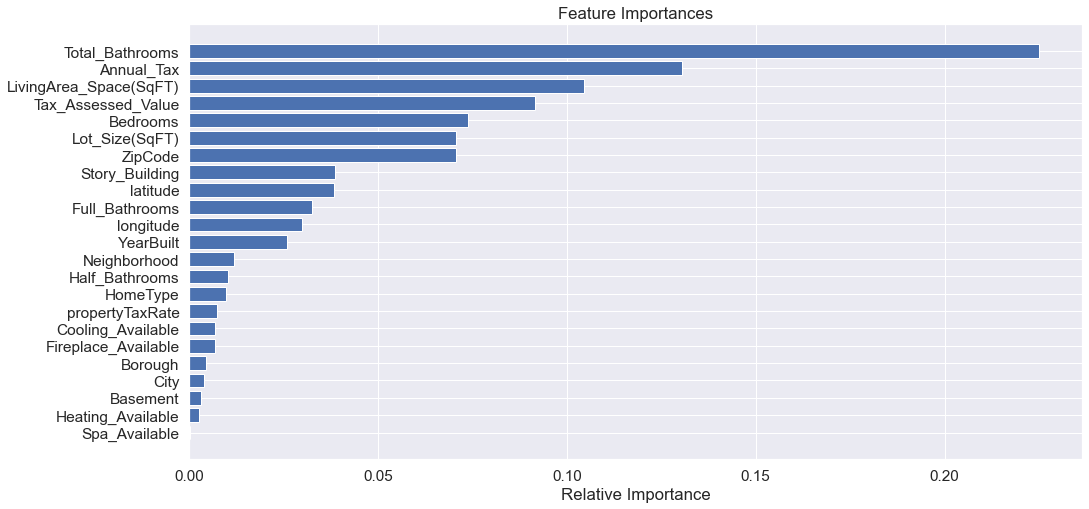

In [37]:
features = X_train_mean.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-26:] 
plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [38]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count', '%'])

count          %
City                        0   0.000000
Borough                     0   0.000000
Neighborhood                0   0.000000
ZipCode                     0   0.000000
latitude                    0   0.000000
longitude                   0   0.000000
price                       0   0.000000
HomeType                    0   0.000000
Bedrooms                    0   0.000000
Total_Bathrooms             0   0.000000
Basement                    0   0.000000
Cooling_Available           0   0.000000
Fireplace_Available         0   0.000000
Heating_Available           0   0.000000
Spa_Available               0   0.000000
Story_Building              0   0.000000
propertyTaxRate            12   0.020249
YearBuilt                3875   6.538760
LivingArea_Space(SqFT)   7189  12.130876
Annual_Tax               8656  14.606324
Lot_Size(SqFT)           9276  15.652526
$_Per_SqFT               9276  15.652526
Tax_Assessed_Value      10447  17.628497
Half_Bathrooms          13919  23.487226
Full_Bathrooms          13981  23.591846

#### It seems the following had little to no impact on price, 'Basement', 'Cooling_Available', 'Fireplace_Available', 'Heating_Available', 'Spa_Available', 'City, 'Borough' and both Full_Bathrooms and Half_Bathrooms have high ratio of high missing data. 

In [39]:
X_train_im = X_train.drop(['Basement', 'Cooling_Available', 'Fireplace_Available', 'Heating_Available', 'Spa_Available', 'City', 'Borough', 'Full_Bathrooms', 'Half_Bathrooms'],axis=1)
X_test_im = X_test.drop(['Basement', 'Cooling_Available', 'Fireplace_Available', 'Heating_Available', 'Spa_Available', 'City', 'Borough', 'Full_Bathrooms', 'Half_Bathrooms'],axis=1)


In [40]:
train_TaxRate = X_train_im[X_train_im.propertyTaxRate.isnull()].index
for i in train_TaxRate:
    x  = (X_train_im.ZipCode[i])
    y = X_train_im.propertyTaxRate[i]
    y = (round(np.mean(X_train_im[X_train_im.ZipCode == x].propertyTaxRate),3))
    X_train_im.propertyTaxRate[i] = y

    
test_TaxRate = X_test_im[X_test_im.propertyTaxRate.isnull()].index
for i in test_TaxRate:
    x  = (X_test_im.ZipCode[i])
    y = X_test_im.propertyTaxRate[i]
    y = (round(np.mean(X_test_im[X_test_im.ZipCode == x].propertyTaxRate),3))
    X_test_im.propertyTaxRate[i] = y
    

In [41]:
train_meananTax = X_train_im[X_train_im.Annual_Tax.isnull()].index
for i in train_meananTax:
    x  = (X_train_im.ZipCode[i])
    y = X_train_im.Annual_Tax[i]
    y = (round(np.mean(X_train_im[X_train_im.ZipCode == x].Annual_Tax),3))
    X_train_im.Annual_Tax[i] = y
    
test_meananTax = X_test_im[X_test_im.Annual_Tax.isnull()].index
for i in test_meananTax:
    x  = (X_test_im.ZipCode[i])
    y = X_test_im.Annual_Tax[i]
    y = (round(np.mean(X_test_im[X_test_im.ZipCode == x].Annual_Tax),3))
    X_test_im.Annual_Tax[i] = y

In [42]:
train_meanTATax = X_train_im[X_train_im.Tax_Assessed_Value.isnull()].index
for i in train_meanTATax:
    x  = (X_train_im.ZipCode[i])
    y = X_train_im.Tax_Assessed_Value[i]
    y = (round(np.mean(X_train_im[X_train_im.ZipCode == x].Tax_Assessed_Value),3))
    X_train_im.Tax_Assessed_Value[i] = y

test_meanTATax = X_test_im[X_test_im.Tax_Assessed_Value.isnull()].index
for i in test_meanTATax:
    x  = (X_test_im.ZipCode[i])
    y = X_test_im.Tax_Assessed_Value[i]
    y = (round(np.mean(X_test_im[X_test_im.ZipCode == x].Tax_Assessed_Value),3))
    X_test_im.Tax_Assessed_Value[i] = y

In [43]:
train_meanYRTax = X_train_im[X_train_im.YearBuilt.isnull()].index
for i in train_meanYRTax:
    x  = (X_train_im.ZipCode[i])
    y = X_train_im.YearBuilt[i]
    y = (round(np.mean(X_train_im[X_train_im.ZipCode == x].YearBuilt),3))
    X_train_im.YearBuilt[i] = y
    
test_meanYRTax = X_test_im[X_test_im.YearBuilt.isnull()].index
for i in test_meanYRTax:
    x  = (X_test_im.ZipCode[i])
    y = X_test_im.YearBuilt[i]
    y = (round(np.mean(X_test_im[X_test_im.ZipCode == x].YearBuilt),3))
    X_test_im.YearBuilt[i] = y

In [44]:
train_meanLATax = X_train_im[X_train_im['LivingArea_Space(SqFT)'].isnull()].index
for i in train_meanLATax:
    x  = (X_train_im.ZipCode[i])
    y = X_train_im['LivingArea_Space(SqFT)'][i]
    y = (round(np.mean(X_train_im[X_train_im.ZipCode == x]['LivingArea_Space(SqFT)']),3))
    X_train_im['LivingArea_Space(SqFT)'][i] = y
    
    
test_meanLATax = X_test_im[X_test_im['LivingArea_Space(SqFT)'].isnull()].index
for i in test_meanLATax:
    x  = (X_test_im.ZipCode[i])
    y = X_test_im['LivingArea_Space(SqFT)'][i]
    y = (round(np.mean(X_test_im[X_test_im.ZipCode == x]['LivingArea_Space(SqFT)']),3))
    X_test_im['LivingArea_Space(SqFT)'][i] = y

In [45]:
train_meanLATax = X_train_im[X_train_im['Lot_Size(SqFT)'].isnull()].index
for i in train_meanLATax:
    x  = (X_train_im.ZipCode[i])
    y = X_train_im['Lot_Size(SqFT)'][i]
    y = (round(np.mean(X_train_im[X_train_im.ZipCode == x]['Lot_Size(SqFT)']),3))
    X_train_im['Lot_Size(SqFT)'][i] = y
    
    
test_meanLATax = X_test_im[X_test_im['Lot_Size(SqFT)'].isnull()].index
for i in test_meanLATax:
    x  = (X_test_im.ZipCode[i])
    y = X_test_im['Lot_Size(SqFT)'][i]
    y = (round(np.mean(X_test_im[X_test_im.ZipCode == x]['Lot_Size(SqFT)']),3))
    X_test_im['Lot_Size(SqFT)'][i] = y

In [46]:
X_train_im = X_train_im.fillna(X_train_im.mean())
X_test_im = X_test_im.fillna(X_test_im.mean())

In [47]:
rf = RandomForestRegressor(random_state=100, max_depth=10)
rf.fit(X_train_im,y_train)
y_train_im_pred = rf.predict(X_train_im)
y_test_im_pred = rf.predict(X_test_im)

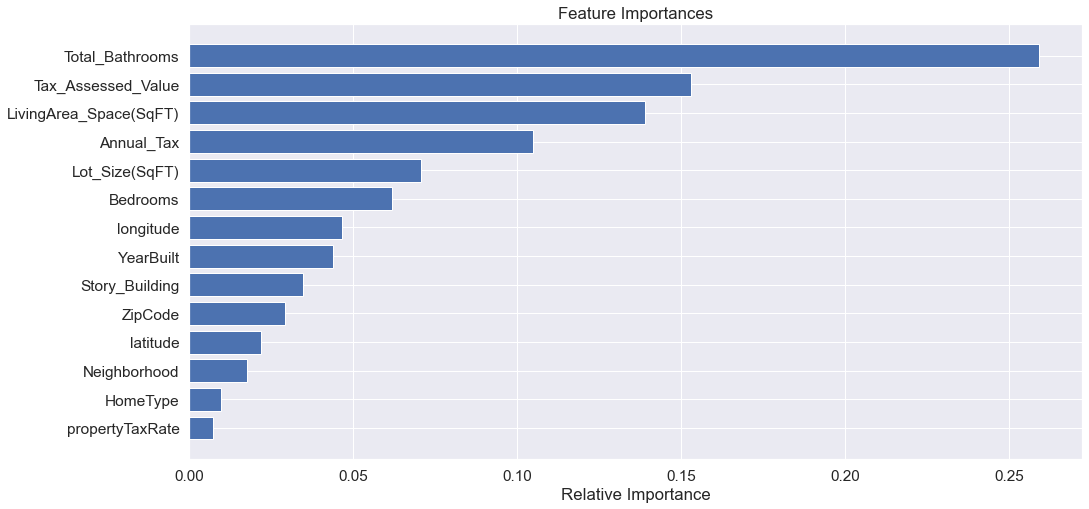

In [48]:
features = X_train_im.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-26:] 
plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [49]:
print("R2 of Y_train zipcode mean prediction's:", r2_score(y_train, y_train_im_pred))
print("R2 of Y_test zipcode mean prediction's:",r2_score(y_test, y_test_im_pred))
print("MAE of Y_train zipcode mean prediction's:",mean_absolute_error(y_train, y_train_im_pred))
print("MAE of Y_test zipcode mean prediction's:",mean_absolute_error(y_test, y_test_im_pred))

R2 of Y_train zipcode mean prediction's: 0.8824516875867265
R2 of Y_test zipcode mean prediction's: 0.6281513477136729
MAE of Y_train zipcode mean prediction's: 263302.42714863975
MAE of Y_test zipcode mean prediction's: 339059.48904137703


In [50]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=100, max_depth=10)
model.fit(X_train.fillna(X_train.mean()),y_train)

RandomForestRegressor(max_depth=10, random_state=100)

In [51]:
y_pred_test = model.predict(X_test.fillna(X_test.mean()))
y_pred_train = model.predict(X_train.fillna(X_train.mean()))
print(r2_score(y_test, y_pred_test),r2_score(y_train, y_pred_train)) 

0.642122319659992 0.8923610089389832


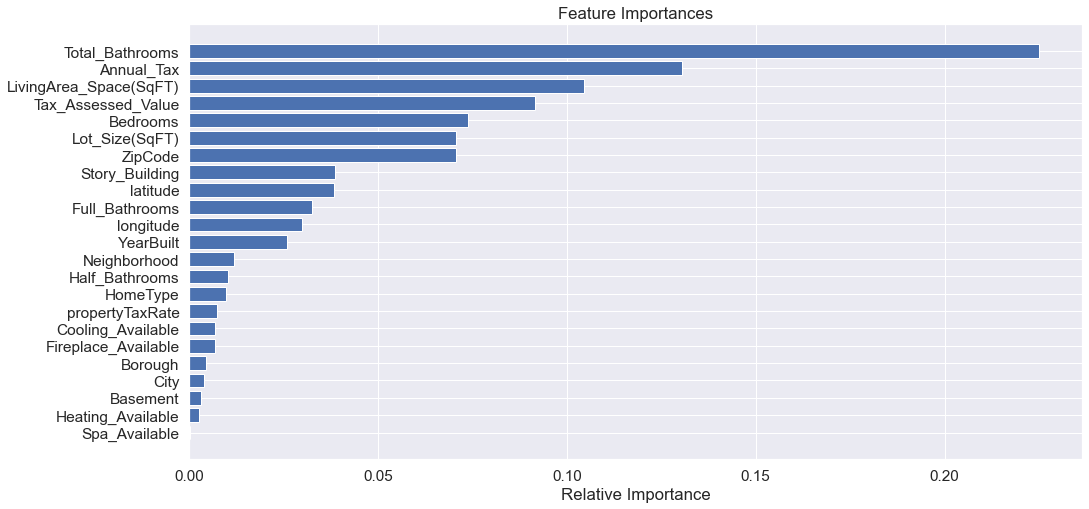

In [52]:
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-26:] 
plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### It seems that the following have little to no impact Neighborhood, ParkingType, City, Heating_Available, Half_Bathrooms, Fireplace, Cooling, Basement, and Spa_Available. Lets remove these features and try to see if we yield a better r2_score. Even though full_bathrooms might have some indication I am going to input on the train data and with 0 for missing values for it. 

In [53]:
train_df_2 = df.drop(columns=['City', 'Neighborhood', 'Half_Bathrooms',
       'Basement', 'Cooling_Available', 'Fireplace_Available',
       'Heating_Available', 'Spa_Available'], axis=1)

In [54]:
train_df_2.Full_Bathrooms.fillna(0)

0        1.0
1        7.0
2        3.0
3        6.0
4        5.0
        ... 
59257    0.0
59258    5.0
59259    4.0
59260    0.0
59261    1.0
Name: Full_Bathrooms, Length: 59262, dtype: float64

In [55]:
train_df_2 = train_df_2.dropna()

In [56]:
X_2 = train_df_2.drop([ 'price', '$_Per_SqFT'] ,axis=1)
y_2 = train_df_2.price

In [57]:
X_2.shape
#While our dataset definately reduced its still a alot to work with I don't believe we will overfit as we still have 35k observations

(33283, 15)

In [97]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=.3, random_state=100)
rf = RandomForestRegressor(random_state=100, max_depth=10)
rf.fit(X_train_2,y_train_2)

RandomForestRegressor(max_depth=10, random_state=100)

In [98]:
y_pred = rf.predict(X_test_2)
print(r2_score(y_test_2, y_pred))
y_pred = rf.predict(X_train_2)
print(r2_score(y_train_2, y_pred))

0.6457979953539843
0.9317301155133008


#### These are the best results so far I think this is the best iterations of our training and test dataset and in our next notebook of modeling we will further fine tune and select the best machine learning algorithm to perform further test to get the best model.

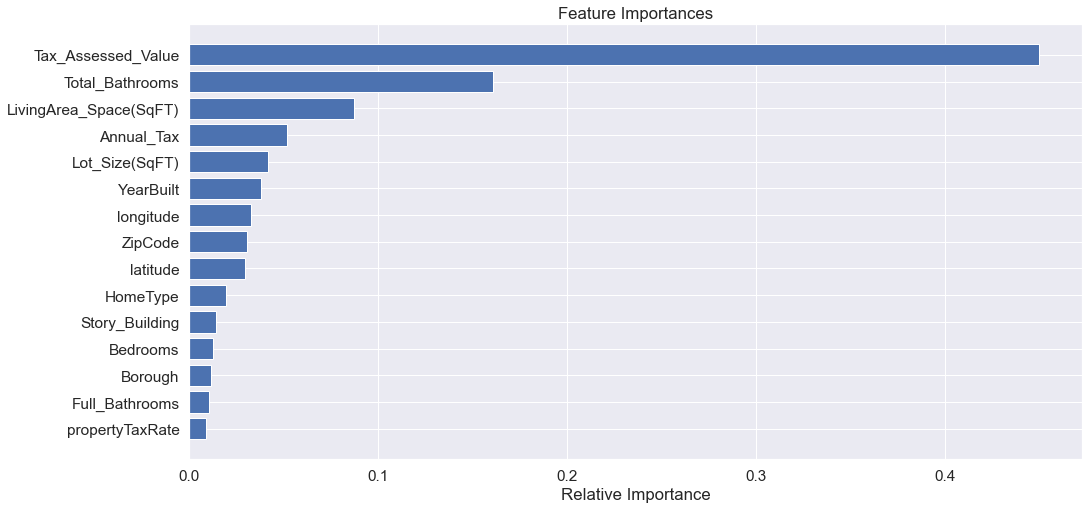

In [61]:
features = X_train_2.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-26:] 
plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### That was a great move, our R2_score has increased significantly so now we know which features to drop

## 3.10 Gradient Boosting Model

In [195]:
import xgboost as xgb

In [161]:
X = df.drop(['price', '$_Per_SqFT', 'Basement', 'Cooling_Available', 'Fireplace_Available', 'Heating_Available', 'Spa_Available', 'Story_Building'], axis=1).values
y = df.price.values

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, random_state=100)

In [187]:
GB_pipe = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    xgb.XGBRegressor(random_state=100)
)

In [188]:
GB_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=100,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [189]:
test_preds = GB_pipe.predict(X_test)
train_preds = GB_pipe.predict(X_train)

In [190]:
print("R2 of Y_train  GB prediction's:", r2_score(y_train, train_preds))
print("R2 of Y_test  GB prediction's:",r2_score(y_test, test_preds))
print("MAE of Y_train GB prediction's:",mean_absolute_error(y_train, train_preds))
print("MAE of Y_test GB prediction's:",mean_absolute_error(y_test, test_preds))

R2 of Y_train  GB prediction's: 0.9741759065696112
R2 of Y_test  GB prediction's: 0.6996805761399063
MAE of Y_train GB prediction's: 180355.2365092847
MAE of Y_test GB prediction's: 303310.0333122832


In [196]:
gb_default_cv_results = cross_validate(GB_pipe, X_train, y_train, cv=5)

In [197]:
gb_default_cv_results

{'fit_time': array([2.06351519, 2.11086369, 2.0594914 , 2.19075632, 2.14032054]),
 'score_time': array([0.00994682, 0.00997376, 0.00897646, 0.00996733, 0.00997376]),
 'test_score': array([0.62674508, 0.60764391, 0.52406885, 0.47358701, 0.45281   ])}

In [191]:
gb = xgb.XGBRegressor(random_state=100)

In [192]:
gb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [193]:
pred_test = gb.predict(X_test)
pred_train = gb.predict(X_train)

In [194]:
print("R2 of Y_train  GB prediction's:", r2_score(y_train, pred_train))
print("R2 of Y_test  GB prediction's:",r2_score(y_test, pred_test))
print("MAE of Y_train GB prediction's:",mean_absolute_error(y_train, pred_train))
print("MAE of Y_test GB prediction's:",mean_absolute_error(y_test, pred_test))

R2 of Y_train  GB prediction's: 0.9775269151565826
R2 of Y_test  GB prediction's: 0.6903184316727289
MAE of Y_train GB prediction's: 171554.1046687236
MAE of Y_test GB prediction's: 304751.44898669753


In [171]:
gb_cv_scores = gb_default_cv_results['test_score']
gb_cv_scores

array([0.99915482, 0.9991563 , 0.99902509, 0.99474051, 0.99925765])

In [172]:
np.mean(gb_cv_scores), np.std(gb_cv_scores)

(0.9982668767594177, 0.0017647263148281378)

### 3.11 Hyper-parameter Tuning  with Gradient Boost 

In [213]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [198]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}


In [206]:
params['eval_metric'] = "mae"
num_boost_round = 999
evallist  = [(X_test,'eval'), (X_train,'train')]


In [214]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[23:37:56] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:763658.81250
[1]	Test-mae:562080.43750
[2]	Test-mae:445592.68750
[3]	Test-mae:376867.84375
[4]	Test-mae:339311.78125
[5]	Test-mae:323415.90625
[6]	Test-mae:316051.37500
[7]	Test-mae:314485.00000
[8]	Test-mae:314545.81250
[9]	Test-mae:312820.18750
[10]	Test-mae:313140.59375
[11]	Test-mae:313317.37500
[12]	Test-mae:311008.93750
[13]	Test-mae:310372.28125
[14]	Test-mae:311191.18750
[15]	Test-mae:311862.75000
[16]	Test-mae:311248.93750
[17]	Test-mae:310879.50000
[18]	Test-mae:310810.75000
[19]	Test-mae:310165.25000
[20]	Test-mae:310303.50000
[21]	Test-mae:310128.50000
[22]	Test-mae:310298.62500
[23]	Test-mae:309860.75000
[24]	Test-mae:309728.46875
[25]	Test-mae:309975.18750
[26]	Test-mae:310187.31250
[27]	Test-mae:309723.62500
[28]	Test-mae:309615.37500
[29]	Test-mae:309258.50000
[30]	Test-mae:309084.15625
[31]	Test-mae:308

In [215]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 307356.78 with 35 rounds


In [217]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=100,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results


[23:39:26] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:26] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:26] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:26] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:26] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0     768476.500000    5215.742696   775174.86250  24571.724050
1     565212.562500    4645.967786   582054.91250  22249.788326
2     439170.518750    4050.189287   466878.76250  19855.637274
3     364161.656250    5023.644873   401852.08125  16774.643721
4     323418.150000    5345.917147   368252.22500  15118.656148
..              ...            ...            ...           ...
125   150730.650000    1324.758380   314705.83125  12981.902668
126   150099.481250    1499.317920   314673.32500  12931.900848
127   149646.021875    1719.569284   314570.48750  12987.417432
128   149221.334375    1637.283592   314449.82500  12968.432644
129   148737.525000    1671.078566   314303.87500  12956.085030

[130 rows x 4 columns]

In [218]:
cv_results['test-mae-mean'].min()

314303.875

In [220]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,15)
    for min_child_weight in range(3,9)
]

In [221]:
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=5, min_child_weight=3
[23:41:28] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:41:28] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:41:28] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:41:28] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:41:28] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 333416.7625 for 55 rounds
CV with max_depth=5, min_child_weight=4
[23:41:33] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear i

	MAE 340895.125 for 9 rounds
CV with max_depth=6, min_child_weight=7
[23:42:23] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:23] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:23] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:23] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:23] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 338480.4375 for 10 rounds
CV with max_depth=6, min_child_weight=8
[23:42:26] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regres

[23:42:58] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:58] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:59] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 324162.875 for 8 rounds
CV with max_depth=8, min_child_weight=5
[23:43:03] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:03] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:03] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squareder

[23:43:41] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:41] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:41] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 320516.43125 for 8 rounds
CV with max_depth=10, min_child_weight=3
[23:43:45] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:45] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:45] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:square

[23:44:33] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:33] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:33] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 319091.80625 for 7 rounds
CV with max_depth=11, min_child_weight=7
[23:44:38] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:38] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:38] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:square

[23:45:33] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:33] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:33] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:34] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 312885.23125 for 8 rounds
CV with max_depth=13, min_child_weight=5
[23:45:39] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:40] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:square

	MAE 316366.41875 for 8 rounds
CV with max_depth=14, min_child_weight=8
[23:46:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:46:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:46:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:46:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:46:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 313221.99375 for 7 rounds
Best params: 14, 3, MAE: 310360.65625


In [222]:
params['max_depth'] = 14
params['min_child_weight'] = 3

In [223]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [224]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[23:50:00] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:01] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:01] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:01] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:01] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 310360.65625 for 9 rounds
CV with subsample=1.0, colsample=0.9
[23:50:06] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now 

[23:50:58] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:58] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 322867.70625 for 8 rounds
CV with subsample=0.8, colsample=0.8
[23:51:05] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:05] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:05] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:05] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederr

In [225]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

In [ ]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Wall time: 0 ns
CV with eta=0.3
Wall time: 0 ns
[23:52:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:52:43] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 310360.65625 for 9 rounds

CV with eta=0.2
Wall time: 0 ns
[23:52:48] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear 

In [ ]:
params['eta'] = .01


In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

In [ ]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

In [ ]:
mean_absolute_error(best_model.predict(dtest), y_test)


In [ ]:
best_model.save_model("xgb_model.model")
